In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train_updated.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb',
 'train_updated.csv.zip']

In [12]:
os.listdir(PROCESSED_PATH)

['target.csv', 'context_raw_data.csv', 'raw_data.csv']

In [13]:
from data.util import filter_by_date, filter_by_id

In [14]:
raw_prediction = pd.read_csv( 'prediction/drop_lstm/april_to_jul.csv', parse_dates=['date'])

In [15]:
raw_prediction

,yhat1,yhat2,yhat3,yhat4,target1,target2,target3,target4,date,playerId
0,1.021850,11.515089,0.428298,15.365670,9.051319,37.249410,84.337685,61.795190,2021-04-01,405395
1,18.388480,21.680859,8.543251,25.408033,23.797577,16.486390,1.830379,43.453770,2021-04-02,405395
2,0.832838,11.832278,0.537509,15.734527,1.582325,11.661470,0.446259,16.009968,2021-04-03,405395
3,0.593775,11.363600,0.254093,14.432013,0.398015,17.862383,0.236858,11.990868,2021-04-04,405395
4,1.384460,14.508149,0.638930,17.683853,0.105217,29.070086,0.311580,18.445448,2021-04-05,405395
...,...,...,...,...,...,...,...,...,...,...
128191,0.000016,0.028266,0.000005,0.021659,0.001183,0.185048,0.001660,0.191695,2021-07-13,685503
128192,0.000018,0.024033,0.000004,0.020871,0.003569,0.263286,0.000000,0.235223,2021-07-14,685503
128193,0.000034,0.054639,0.000010,0.032916,0.002493,0.252499,0.002260,0.330065,2021-07-15,685503
128194,0.000043,0.059577,0.000012,0.036631,0.001662,0.203081,0.000722,0.258152,2021-07-16,685503


### preprocessing with pipelines

In [16]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info
from pipeline.core import forward_fill, gen_hardcoded_features, fillna

In [22]:
from data.split import SplitData

In [23]:
from typing import List

def create_player_matrix(df: pd.DataFrame,
                         features: List[str] = None,
                         on: str = ['playerId']):    
    outputX = df.pivot('date', on, values=features)
    outputX.columns = ['__'.join(on + list(map(str, f)))
                       for f in outputX.columns]
    
    sorted_columns = sorted(outputX.columns)
    return outputX.loc[:, sorted_columns].reset_index()    

In [24]:
yhat_cols = ['yhat1', 'yhat2', 'yhat3', 'yhat4']
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [143]:
features = create_player_matrix(raw_prediction, features=['yhat2'])

In [146]:
# split the data on 2021-03-01 with a valid ds of 61 days
sp = SplitData("2021-05-01", test_days=500)

In [147]:
train_idx = sp.train_idx(features)
valid_idx = sp.valid_idx(features)

In [148]:
target = filter_by_id(raw_prediction, [660271])[pp_cols]

In [149]:
train_features = sp.filter(features, train_idx)
train_target = sp.filter(target, train_idx)

In [150]:
valid_features = sp.filter(features, valid_idx)
valid_target = sp.filter(target, valid_idx)

In [151]:
train_features.shape, train_target.shape

((30, 1188), (30, 6))

In [152]:
valid_features.shape, valid_target.shape

((78, 1188), (78, 6))

### modeling 

In [153]:
cont_features = features.columns.drop('date'); cont_features

Index(['playerId__yhat2__405395', 'playerId__yhat2__408234',
       'playerId__yhat2__424144', 'playerId__yhat2__425772',
       'playerId__yhat2__425784', 'playerId__yhat2__425794',
       'playerId__yhat2__425844', 'playerId__yhat2__425877',
       'playerId__yhat2__429722', 'playerId__yhat2__431148',
       ...
       'playerId__yhat2__680430', 'playerId__yhat2__680692',
       'playerId__yhat2__680704', 'playerId__yhat2__680777',
       'playerId__yhat2__680911', 'playerId__yhat2__680963',
       'playerId__yhat2__681911', 'playerId__yhat2__683232',
       'playerId__yhat2__683734', 'playerId__yhat2__685503'],
      dtype='object', length=1187)

In [159]:
features['maximum'] = features[cont_features].max(axis=1)

In [160]:
from sklearn.linear_model import Lasso
from lightgbm import LGBMRegressor

In [161]:
models = []
for target_name in target_cols:
    _model = Lasso(max_iter=12000, alpha=0.1)
    _model.fit(train_features[cont_features], train_target[target_name].to_numpy())
    models.append(_model)
    
prediction = np.clip(np.stack([_model.predict(valid_features[cont_features])
                               for _model in models], axis=1), 0, 100)

In [162]:
from evaluate.metrics import compute_metrics


In [163]:
valid_test_prediction = pd.DataFrame(prediction, columns=yhat_cols)

In [164]:
valid_test_prediction[pp_cols] = valid_target[pp_cols]
recursive_prediction=valid_test_prediction

In [165]:
# valid_test_prediction.loc[hardest_idx].head()

In [166]:
# valid_test_prediction_with_last_mean.loc[hardest_idx].head()

In [167]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 30.82336246687002,
 'mae_1': 35.419783245133814,
 'mae_2': 29.12925212199022,
 'mae_3': 30.880996108086045,
 'mae_4': 27.86341839226999}

In [168]:
(valid_test_prediction.groupby(valid_test_prediction.date.dt.month)
 .apply(lambda x: pd.Series(compute_metrics(x))))

,mae_mean,mae_1,mae_2,mae_3,mae_4
date,,,,,
5,37.837818,38.818374,40.305800,33.494440,38.732656
6,28.905649,28.686833,27.455233,32.026795,27.453736
7,21.416497,41.104031,11.702639,24.093305,8.766012


In [137]:
# metrics from 2021-03-01 up to 2021-04-30
compute_metrics(valid_test_prediction)

{'mae_mean': 30.82336246687002,
 'mae_1': 35.419783245133814,
 'mae_2': 29.12925212199022,
 'mae_3': 30.880996108086045,
 'mae_4': 27.86341839226999}

In [138]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

def plot_feature_vs_target(df, feature, playerId, index=1):
    pdf = df.query(f'raw_playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    twinx = ax.twinx()
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    twinx.plot('date', feature, '-o', data=pdf, label=feature, color='red')
    twinx.legend()
    ax.set_title(f'{tname} vs {feature}')
    

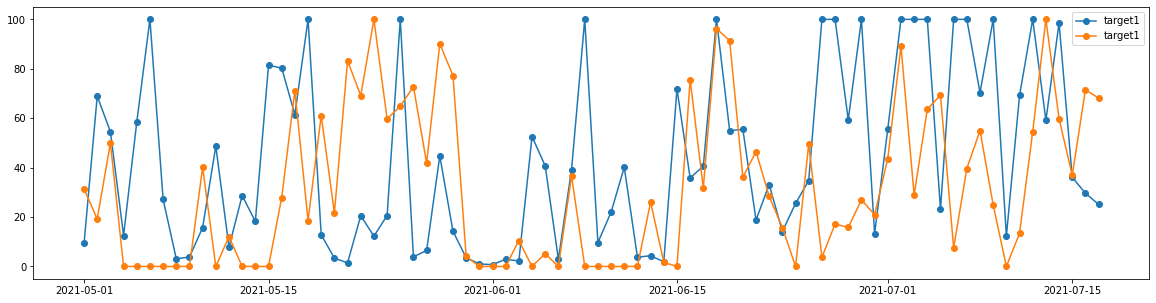

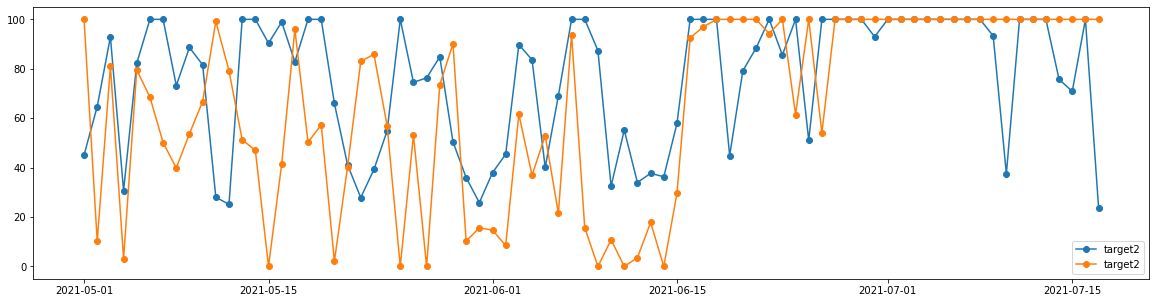

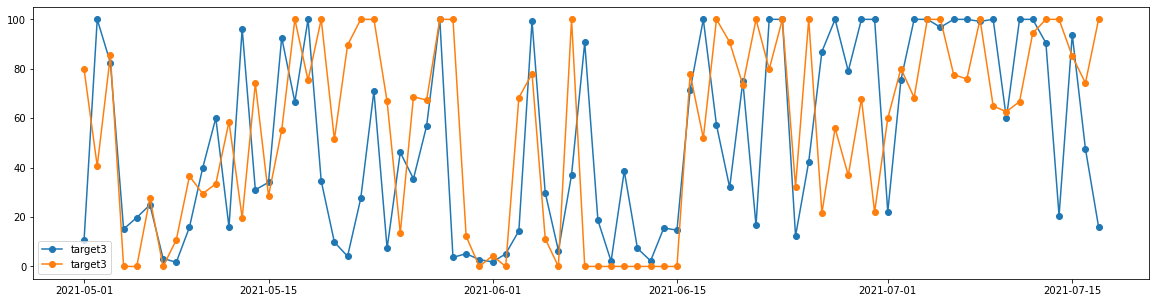

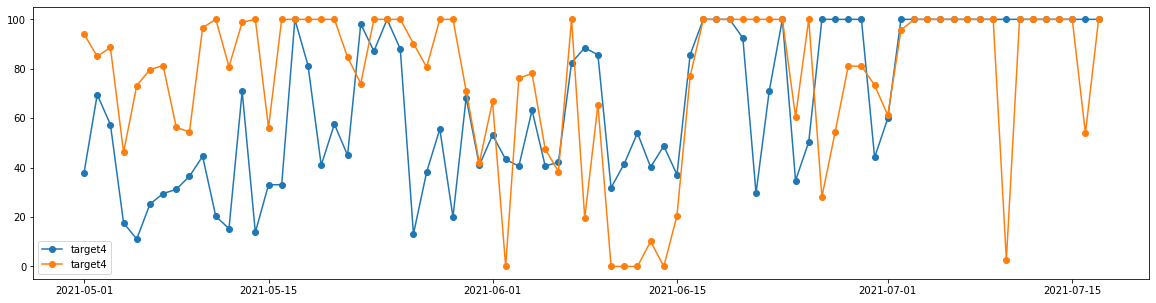

In [140]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

In [114]:
fi = pd.DataFrame({'feature': cont_features,
                   'importance': _model.feature_importances_}).sort_values(by=['importance'], ascending=False)

In [116]:
pd.options.display.max_rows = 50
fi.head(50)

,feature,importance
0,playerId__yhat2__405395,0
797,playerId__yhat2__642547,0
795,playerId__yhat2__642528,0
794,playerId__yhat2__642456,0
793,playerId__yhat2__642423,0
792,playerId__yhat2__642397,0
791,playerId__yhat2__642336,0
790,playerId__yhat2__642233,0
789,playerId__yhat2__642232,0
788,playerId__yhat2__642221,0


In [169]:
pd.options.display.max_rows = 50
fi.tail(50)

,feature,importance
1898,playerId__yhat2__640464,0.0
1901,playerId__yhat2__641302,0.0
1902,playerId__yhat2__641312,0.0
1903,playerId__yhat2__641313,0.0
1904,playerId__yhat2__641343,0.0
1905,playerId__yhat2__641355,0.0
1907,playerId__yhat2__641386,0.0
1908,playerId__yhat2__641394,0.0
1909,playerId__yhat2__641401,0.0
1912,playerId__yhat2__641447,0.0


In [ ]:
for index in range(1, 5):
    plot_feature_vs_target(valid_data, 'playerTeamoutsPitching__date__maxNorm', playerId=660271, index=index)

In [107]:
output_path = 'prediction/drop_lstm'
os.makedirs(output_path, exist_ok=True)

In [108]:
valid_test_prediction.to_csv(os.path.join(output_path, 'april_to_jul.csv'), index=False)